# ACLO Project: Check-in Behavior Analysis

This notebook contains a complete data science pipeline analyzing gym/facility check-in behavior based on:
- Membership types and cardholder data (2020-2022)
- Special calendar days (academic calendar)
- Check-in timestamps (2017-2021)

**Goal:** Predict check-in patterns and identify key factors influencing member activity.

## 1. Setup and Data Loading

### Import Required Libraries

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve,
                             r2_score, mean_squared_error, mean_absolute_error)

# For DAG visualization
import networkx as nx

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### Load All Three Datasets

In [2]:
# Load the three datasets
membership_df = pd.read_csv('Data/Kaikki membership tyypit vuodet 2020-2022.csv')
special_days_df = pd.read_csv('Data/Yhdistetyt_p_iv_t__aikaj_rjestyksess__.csv')
checkins_df = pd.read_csv('Data/Check-in-times_sheet_2017-2021 kaikki checkin timet yhes.csv')

print("✓ All datasets loaded successfully")
print(f"\n1. Membership data shape: {membership_df.shape}")
print(f"2. Special days data shape: {special_days_df.shape}")
print(f"3. Check-ins data shape: {checkins_df.shape}")

✓ All datasets loaded successfully

1. Membership data shape: (32833, 4)
2. Special days data shape: (164, 4)
3. Check-ins data shape: (380785, 5)


### Dataset 1: Membership Data (2020-2022)

In [3]:
# Membership dataset - basic exploration
print("=" * 80)
print("MEMBERSHIP DATA OVERVIEW")
print("=" * 80)
print(f"\nShape: {membership_df.shape}")
print(f"\nFirst few rows:")
print(membership_df.head())
print(f"\nData types and non-null counts:")
print(membership_df.info())
print(f"\nMissing values per column:")
print(membership_df.isnull().sum())
print(f"\nBasic statistics:")
print(membership_df.describe(include='all'))

MEMBERSHIP DATA OVERVIEW

Shape: (32833, 4)

First few rows:
  Card Number Gender Male Gender Female          Description
0      206602         NaN        Female  ACLO Card 2020-2021
1      220965         NaN        Female  ACLO Card 2020-2021
2      221004        Male           NaN  ACLO Card 2020-2021
3      200011        Male           NaN  ACLO Card 2020-2021
4      187611        Male           NaN  ACLO Card 2020-2021

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Card Number    32833 non-null  object
 1   Gender Male    14906 non-null  object
 2   Gender Female  17122 non-null  object
 3   Description    32833 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB
None

Missing values per column:
Card Number          0
Gender Male      17927
Gender Female    15711
Description          0
dtype: in

### Dataset 2: Special Days (Academic Calendar)

In [4]:
# Special days dataset - basic exploration
print("=" * 80)
print("SPECIAL DAYS DATA OVERVIEW")
print("=" * 80)
print(f"\nShape: {special_days_df.shape}")
print(f"\nFirst few rows:")
print(special_days_df.head())
print(f"\nData types and non-null counts:")
print(special_days_df.info())
print(f"\nMissing values per column:")
print(special_days_df.isnull().sum())
print(f"\nBasic statistics:")
print(special_days_df.describe(include='all'))

SPECIAL DAYS DATA OVERVIEW

Shape: (164, 4)

First few rows:
         date                     event_name       event_type  \
0  2017-09-04  Getting Started (Orientation)  Getting started   
1  2017-09-05  Getting Started (Orientation)  Getting started   
2  2017-09-06  Getting Started (Orientation)  Getting started   
3  2017-09-26            EQUIS Accreditation    Special event   
4  2017-09-27            EQUIS Accreditation    Special event   

                   notes  
0  First-year onboarding  
1  First-year onboarding  
2  First-year onboarding  
3     Accreditation days  
4     Accreditation days  

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        164 non-null    object
 1   event_name  164 non-null    object
 2   event_type  164 non-null    object
 3   notes       104 non-null    object
dtypes: o

### Dataset 3: Check-in Times (2017-2021)

In [5]:
# Check-ins dataset - basic exploration
print("=" * 80)
print("CHECK-INS DATA OVERVIEW")
print("=" * 80)
print(f"\nShape: {checkins_df.shape}")
print(f"\nFirst few rows:")
print(checkins_df.head())
print(f"\nData types and non-null counts:")
print(checkins_df.info())
print(f"\nMissing values per column:")
print(checkins_df.isnull().sum())
print(f"\nBasic statistics:")
print(checkins_df.describe(include='all'))

CHECK-INS DATA OVERVIEW

Shape: (380785, 5)

First few rows:
   Card nr          Affiliation  Gender      Subscription visit  \
0   168236  Medewerker RUG            M  Fitness Card 2016-2017   
1   132339            RUG             M  Fitness Card 2016-2017   
2   141170            RUG             M  Fitness Card 2016-2017   
3   141170            RUG             M  Fitness Card 2016-2017   
4   186817            RUG             M  Fitness Card 2016-2017   

    Check-in date  
0  8/1/2017 12:49  
1  8/1/2017 12:53  
2  8/1/2017 12:53  
3  8/1/2017 12:54  
4  8/1/2017 13:00  

Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380785 entries, 0 to 380784
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Card nr             380785 non-null  int64 
 1   Affiliation         355832 non-null  object
 2   Gender              380785 non-null  object
 3   Subscription visit  373

---

## Summary of Data Structure

### Key Findings:

**Dataset 1: Membership Data (32,833 rows, 4 columns)**
- Contains cardholder info with membership types from 2020-2022
- Key columns: `Card Number`, `Gender Male/Female`, `Description` (membership type)
- 21,871 unique cardholders
- Gender is split into two columns (needs cleaning)
- 5 membership types available

**Dataset 2: Special Days (164 rows, 4 columns)**
- Academic calendar events from 2017-2021
- Key columns: `date`, `event_name`, `event_type`, `notes`
- 6 event types: Exams (90 days), Getting started, Special event, etc.
- Most frequent: "Exam Week" (80 occurrences)

**Dataset 3: Check-ins (380,785 rows, 5 columns)**
- Individual check-in events from 2017-2021
- Key columns: `Card nr`, `Affiliation`, `Gender`, `Subscription visit`, `Check-in date`
- 241,617 unique timestamps
- Contains ~24,953 missing affiliations and ~7,774 missing subscription info
- Male members dominate (280,767 check-ins)

### Data Integration Plan:
1. **Join membership + check-ins** on Card Number/Card nr
2. **Enrich with special days** by matching check-in dates with event dates
3. **Extract time features** from check-in timestamps (hour, day of week, month, etc.)

### ⚠️ DECISION POINT: Target Variable

Before proceeding, we need to define the **target variable** for our predictive model.

**Possible options based on the data:**

1. **Classification: High vs Low Activity Member**
   - Target: Binary label (1 = active, 0 = inactive)
   - Example: "Did member check in ≥ X times in a given period?"
   
2. **Classification: Activity Level**
   - Target: Multi-class (e.g., Low / Medium / High activity)
   - Based on quartiles of check-in frequency

3. **Regression: Predict Check-in Count**
   - Target: Numeric value (total check-ins per member per period)
   
4. **Classification: Will Member Return Next Period?**
   - Target: Binary (1 = will check in next month/semester, 0 = won't)

**Questions to answer:**
- What threshold defines "active" vs "inactive"?
- What time period should we use for aggregation (monthly? semester? academic year)?
- Should we predict behavior or just classify existing patterns?

### ✅ TARGET VARIABLES DEFINED

We will build **TWO predictive models**:

1. **REGRESSION MODEL**: Predict total check-ins per member per semester
   - Target: Numeric value (count of check-ins)
   - Use case: Forecast facility usage and member engagement

2. **CLASSIFICATION MODEL**: Predict if member will be active next period
   - Target: Binary (1 = active next period, 0 = inactive)
   - Use case: Identify members at risk of dropping out

**Approach:**
- Aggregate check-ins by member and time period (semester)
- Create features from historical behavior, membership type, and calendar events
- Build and compare multiple models for each task

---

## 2. Data Understanding and Column Analysis

Let's examine each dataset in detail and categorize columns by their purpose.

In [6]:
# Create detailed column analysis for each dataset

def analyze_columns(df, dataset_name):
    """Create a summary table for dataset columns"""
    analysis = []
    for col in df.columns:
        analysis.append({
            'Column': col,
            'Dtype': str(df[col].dtype),
            'Unique Values': df[col].nunique(),
            'Missing Values': df[col].isnull().sum(),
            'Missing %': round(df[col].isnull().sum() / len(df) * 100, 2)
        })
    
    result_df = pd.DataFrame(analysis)
    print(f"\n{'='*80}")
    print(f"{dataset_name} - COLUMN ANALYSIS")
    print(f"{'='*80}\n")
    print(result_df.to_string(index=False))
    return result_df

# Analyze all three datasets
membership_analysis = analyze_columns(membership_df, "MEMBERSHIP DATA")
special_days_analysis = analyze_columns(special_days_df, "SPECIAL DAYS DATA")
checkins_analysis = analyze_columns(checkins_df, "CHECK-INS DATA")


MEMBERSHIP DATA - COLUMN ANALYSIS

       Column  Dtype  Unique Values  Missing Values  Missing %
  Card Number object          21871               0       0.00
  Gender Male object              2           17927      54.60
Gender Female object              2           15711      47.85
  Description object              5               0       0.00

SPECIAL DAYS DATA - COLUMN ANALYSIS

    Column  Dtype  Unique Values  Missing Values  Missing %
      date object            164               0       0.00
event_name object             18               0       0.00
event_type object              6               0       0.00
     notes object              8              60      36.59

CHECK-INS DATA - COLUMN ANALYSIS

            Column  Dtype  Unique Values  Missing Values  Missing %
           Card nr  int64           8476               0       0.00
      Affiliation  object            118           24953       6.55
            Gender object              3               0       0.00
Subs

### Column Purpose Classification

**MEMBERSHIP DATA:**
- `Card Number` → **Key for joining** (cardholder ID)
- `Gender Male/Female` → **Feature** (needs consolidation into one gender column)
- `Description` → **Feature** (membership type: 5 types)

**SPECIAL DAYS DATA:**
- `date` → **Key for joining** (to enrich check-in data)
- `event_name` → **Feature** (18 unique event names)
- `event_type` → **Feature** (6 types: Exams, Getting started, Special event, etc.)
- `notes` → **Drop or use for context** (36% missing)

**CHECK-INS DATA:**
- `Card nr` → **Key for joining** (links to membership)
- `Check-in date` → **Key for time-based features** (timestamp of visit)
- `Affiliation` → **Feature** (university affiliation: 118 types, 6.5% missing)
- `Gender` → **Feature** (3 values: M, F, possibly unknown)
- `Subscription visit` → **Feature** (48 subscription types, 2% missing)

### Next Steps:
1. Clean and standardize data (fix gender columns, parse dates)
2. Merge datasets
3. Engineer time-based and behavioral features
4. Create target variables

---

## 3. Data Cleaning and Preparation

In [7]:
# Clean membership data: consolidate gender columns
membership_clean = membership_df.copy()

# Create single gender column
membership_clean['Gender'] = membership_clean['Gender Male'].fillna(membership_clean['Gender Female'])
membership_clean = membership_clean.drop(columns=['Gender Male', 'Gender Female'])

# Standardize Card Number to integer
membership_clean['Card Number'] = membership_clean['Card Number'].astype(str).str.strip()

print("Membership data cleaned:")
print(f"  - Gender consolidated into single column")
print(f"  - Shape: {membership_clean.shape}")
print(f"\nGender distribution:")
print(membership_clean['Gender'].value_counts())
print(f"\nMembership types:")
print(membership_clean['Description'].value_counts())

Membership data cleaned:
  - Gender consolidated into single column
  - Shape: (32833, 3)

Gender distribution:
Gender
Female           17119
Male             14903
Geslacht Male        3
Name: count, dtype: int64

Membership types:
Description
ACLO Card 2021-2022       16523
ACLO Card 2020-2021       13952
Fitness Card 2021/2022     1371
Fitness Card 2020-2021      984
Omschrijving                  3
Name: count, dtype: int64


In [8]:
# Clean check-ins data: parse dates and standardize columns
checkins_clean = checkins_df.copy()

# Rename columns for consistency
checkins_clean.columns = checkins_clean.columns.str.strip()
checkins_clean = checkins_clean.rename(columns={
    'Card nr': 'Card_Number',
    'Check-in date': 'Checkin_DateTime'
})

# Parse check-in datetime
checkins_clean['Checkin_DateTime'] = pd.to_datetime(checkins_clean['Checkin_DateTime'], format='%m/%d/%Y %H:%M', errors='coerce')

# Extract time-based features
checkins_clean['Date'] = checkins_clean['Checkin_DateTime'].dt.date
checkins_clean['Year'] = checkins_clean['Checkin_DateTime'].dt.year
checkins_clean['Month'] = checkins_clean['Checkin_DateTime'].dt.month
checkins_clean['Day_of_Week'] = checkins_clean['Checkin_DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
checkins_clean['Hour'] = checkins_clean['Checkin_DateTime'].dt.hour
checkins_clean['Day_Name'] = checkins_clean['Checkin_DateTime'].dt.day_name()

# Define semester based on month (Sept-Jan = Semester 1, Feb-June = Semester 2, July-Aug = Summer)
def get_semester(month):
    if month in [9, 10, 11, 12, 1]:
        return 'Semester_1'
    elif month in [2, 3, 4, 5, 6]:
        return 'Semester_2'
    else:
        return 'Summer'

checkins_clean['Semester'] = checkins_clean['Month'].apply(get_semester)

# Convert Card_Number to string for joining
checkins_clean['Card_Number'] = checkins_clean['Card_Number'].astype(str)

print("Check-ins data cleaned:")
print(f"  - DateTime parsed and time features extracted")
print(f"  - Shape: {checkins_clean.shape}")
print(f"\nDate range: {checkins_clean['Date'].min()} to {checkins_clean['Date'].max()}")
print(f"\nSemester distribution:")
print(checkins_clean['Semester'].value_counts())
print(f"\nYear distribution:")
print(checkins_clean['Year'].value_counts().sort_index())

Check-ins data cleaned:
  - DateTime parsed and time features extracted
  - Shape: (380785, 12)

Date range: 2017-08-01 to 2021-12-01

Semester distribution:
Semester
Semester_1    200076
Semester_2    152078
Summer         28631
Name: count, dtype: int64

Year distribution:
Year
2017     43479
2018    107119
2019    131938
2020     67917
2021     30332
Name: count, dtype: int64


In [9]:
# Clean special days data: parse dates
special_days_clean = special_days_df.copy()

# Parse date column
special_days_clean['date'] = pd.to_datetime(special_days_clean['date'], errors='coerce')
special_days_clean['Date'] = special_days_clean['date'].dt.date

print("Special days data cleaned:")
print(f"  - Date column parsed")
print(f"  - Shape: {special_days_clean.shape}")
print(f"\nDate range: {special_days_clean['Date'].min()} to {special_days_clean['Date'].max()}")
print(f"\nEvent types:")
print(special_days_clean['event_type'].value_counts())

Special days data cleaned:
  - Date column parsed
  - Shape: (164, 5)

Date range: 2017-09-04 to 2022-06-24

Event types:
event_type
Exams                90
Public holiday       43
University Closed    17
Getting started       6
Careers Week          5
Special event         3
Name: count, dtype: int64


In [10]:
# Merge check-ins with special days to flag special day check-ins
checkins_enriched = checkins_clean.merge(
    special_days_clean[['Date', 'event_type', 'event_name']], 
    on='Date', 
    how='left'
)

# Create binary flag for special days
checkins_enriched['Is_Special_Day'] = (~checkins_enriched['event_type'].isna()).astype(int)

# Fill missing event types with 'Regular Day'
checkins_enriched['event_type'] = checkins_enriched['event_type'].fillna('Regular Day')

print("Check-ins enriched with special days:")
print(f"  - Shape: {checkins_enriched.shape}")
print(f"\nSpecial day vs regular day:")
print(checkins_enriched['Is_Special_Day'].value_counts())
print(f"\nCheck-ins by event type:")
print(checkins_enriched['event_type'].value_counts())

Check-ins enriched with special days:
  - Shape: (380785, 15)

Special day vs regular day:
Is_Special_Day
0    354356
1     26429
Name: count, dtype: int64

Check-ins by event type:
event_type
Regular Day          354356
Exams                 18351
Public holiday         2510
Careers Week           2087
Special event          1238
University Closed      1140
Getting started        1103
Name: count, dtype: int64


---

## 4. Feature Engineering for Predictive Models

Now we'll create aggregated features at the member-semester level to prepare for both modeling tasks.

In [11]:
# Create a comprehensive feature dataset at Member-Year-Semester level
# This will be the foundation for both regression and classification models

# Aggregate check-ins by Card_Number, Year, and Semester
member_features = checkins_enriched.groupby(['Card_Number', 'Year', 'Semester']).agg({
    'Checkin_DateTime': 'count',  # Total check-ins
    'Hour': 'mean',  # Average check-in hour
    'Day_of_Week': 'mean',  # Average day of week
    'Is_Special_Day': 'sum',  # Number of check-ins on special days
    'Gender': 'first',  # Gender (should be consistent per member)
    'Affiliation': 'first',  # Affiliation
    'Subscription visit': 'first'  # Subscription type
}).reset_index()

# Rename columns
member_features.columns = [
    'Card_Number', 'Year', 'Semester', 'Total_Checkins', 
    'Avg_Checkin_Hour', 'Avg_Day_of_Week', 'Special_Day_Checkins',
    'Gender', 'Affiliation', 'Subscription'
]

# Calculate percentage of check-ins on special days
member_features['Pct_Special_Day_Checkins'] = (
    member_features['Special_Day_Checkins'] / member_features['Total_Checkins'] * 100
).round(2)

# Add membership info
member_features = member_features.merge(
    membership_clean.rename(columns={'Card Number': 'Card_Number'}),
    on='Card_Number',
    how='left'
)

# Handle members not in membership dataset (use check-in gender as fallback)
member_features['Gender_Final'] = member_features['Gender_y'].fillna(member_features['Gender_x'])
member_features = member_features.drop(columns=['Gender_x', 'Gender_y'])
member_features = member_features.rename(columns={'Gender_Final': 'Gender', 'Description': 'Membership_Type'})

print("Member-level features created:")
print(f"  - Shape: {member_features.shape}")
print(f"  - Unique members: {member_features['Card_Number'].nunique()}")
print(f"\nFirst few rows:")
print(member_features.head(10))

Member-level features created:
  - Shape: (34956, 12)
  - Unique members: 8476

First few rows:
  Card_Number  Year    Semester  Total_Checkins  Avg_Checkin_Hour  \
0       10216  2017  Semester_1              25         14.000000   
1       10216  2017      Summer               7         16.000000   
2       10216  2018  Semester_1              44         13.863636   
3       10216  2018  Semester_2              47         13.234043   
4       10216  2018      Summer              14         16.285714   
5       10216  2019  Semester_1              69         13.594203   
6       10216  2019  Semester_2              50         14.020000   
7       10216  2019      Summer              18         15.888889   
8       10216  2020  Semester_1              19         13.105263   
9       10216  2020  Semester_2              30         13.366667   

   Avg_Day_of_Week  Special_Day_Checkins          Affiliation  \
0         2.120000                     2                        
1         1.28

In [12]:
# Create lagged features: add "next period" activity for classification target
# Sort by member and time period
member_features = member_features.sort_values(['Card_Number', 'Year', 'Semester'])

# Define period order for proper sequencing
period_order = {'Summer': 0, 'Semester_1': 1, 'Semester_2': 2}
member_features['Period_Order'] = member_features['Semester'].map(period_order)
member_features = member_features.sort_values(['Card_Number', 'Year', 'Period_Order'])

# Create "next period" check-in count using shift
member_features['Next_Period_Checkins'] = member_features.groupby('Card_Number')['Total_Checkins'].shift(-1)

# Create binary target: Will member be active next period? (>= 5 check-ins = active)
ACTIVITY_THRESHOLD = 5
member_features['Active_Next_Period'] = (member_features['Next_Period_Checkins'] >= ACTIVITY_THRESHOLD).astype(int)

# Remove rows without next period data (last period for each member)
member_features_with_target = member_features[member_features['Next_Period_Checkins'].notna()].copy()

print("Features with targets created:")
print(f"  - Shape: {member_features_with_target.shape}")
print(f"  - Activity threshold: {ACTIVITY_THRESHOLD} check-ins")
print(f"\nTarget distribution (Active_Next_Period):")
print(member_features_with_target['Active_Next_Period'].value_counts())
print(f"\nNext period check-ins statistics:")
print(member_features_with_target['Next_Period_Checkins'].describe())

Features with targets created:
  - Shape: (26480, 15)
  - Activity threshold: 5 check-ins

Target distribution (Active_Next_Period):
Active_Next_Period
1    18488
0     7992
Name: count, dtype: int64

Next period check-ins statistics:
count    26480.000000
mean        16.789690
std         22.254136
min          1.000000
25%          4.000000
50%          9.000000
75%         21.000000
max        433.000000
Name: Next_Period_Checkins, dtype: float64


---

## 5. Directed Acyclic Graph (DAG)

Let's visualize how our independent variables causally influence check-in behavior.

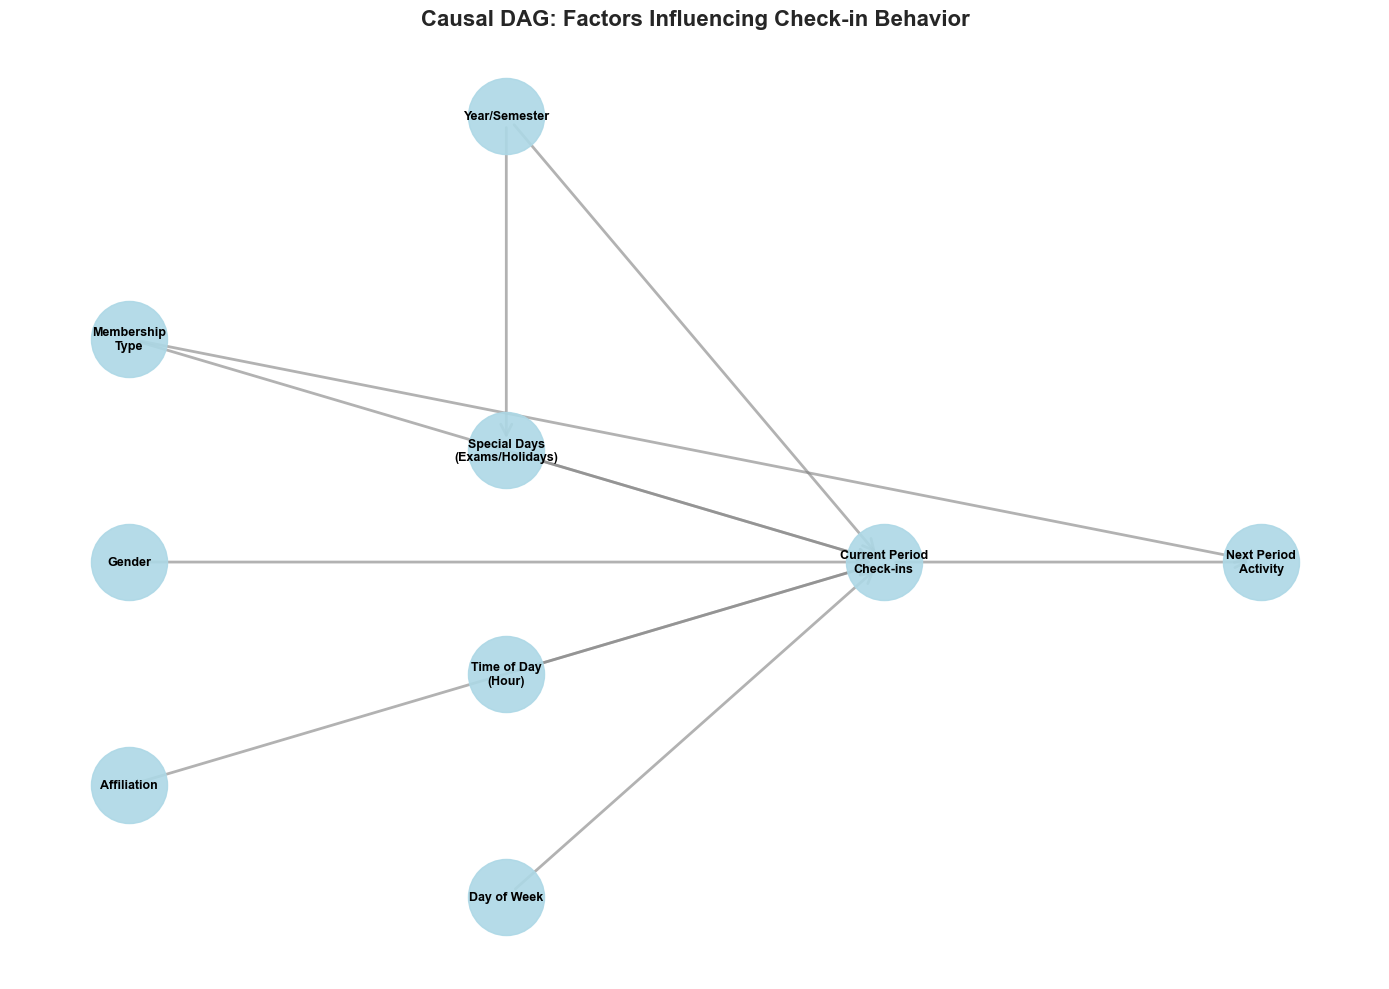

✓ DAG visualization created


In [13]:
# Create a Directed Acyclic Graph showing causal relationships
G = nx.DiGraph()

# Define nodes
nodes = [
    'Membership\nType',
    'Gender',
    'Affiliation',
    'Year/Semester',
    'Special Days\n(Exams/Holidays)',
    'Time of Day\n(Hour)',
    'Day of Week',
    'Current Period\nCheck-ins',
    'Next Period\nActivity'
]

# Add nodes
G.add_nodes_from(nodes)

# Define edges (causal relationships)
edges = [
    ('Membership\nType', 'Current Period\nCheck-ins'),
    ('Gender', 'Current Period\nCheck-ins'),
    ('Affiliation', 'Current Period\nCheck-ins'),
    ('Year/Semester', 'Current Period\nCheck-ins'),
    ('Special Days\n(Exams/Holidays)', 'Current Period\nCheck-ins'),
    ('Time of Day\n(Hour)', 'Current Period\nCheck-ins'),
    ('Day of Week', 'Current Period\nCheck-ins'),
    ('Year/Semester', 'Special Days\n(Exams/Holidays)'),
    ('Current Period\nCheck-ins', 'Next Period\nActivity'),
    ('Membership\nType', 'Next Period\nActivity'),
]

G.add_edges_from(edges)

# Create visualization
plt.figure(figsize=(14, 10))
pos = {
    'Membership\nType': (0, 3),
    'Gender': (0, 2),
    'Affiliation': (0, 1),
    'Year/Semester': (2, 4),
    'Special Days\n(Exams/Holidays)': (2, 2.5),
    'Time of Day\n(Hour)': (2, 1.5),
    'Day of Week': (2, 0.5),
    'Current Period\nCheck-ins': (4, 2),
    'Next Period\nActivity': (6, 2)
}

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, 
                        arrowstyle='->', width=2, alpha=0.6)

plt.title('Causal DAG: Factors Influencing Check-in Behavior', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("✓ DAG visualization created")

### DAG Explanation

**Causal Structure:**

1. **Member Characteristics** (Membership Type, Gender, Affiliation) → directly influence → **Current Period Check-ins**
   - Different membership types may have varying levels of commitment
   - Gender and affiliation may correlate with usage patterns

2. **Temporal Factors** (Year/Semester, Time of Day, Day of Week) → influence → **Current Period Check-ins**
   - Academic calendar drives usage patterns
   - Time preferences affect when members visit

3. **Special Days** (Exams, Holidays) are determined by → **Year/Semester** → and affect → **Check-ins**
   - Exam periods may increase/decrease usage
   - Holidays typically reduce check-ins

4. **Current Period Check-ins** → strong predictor of → **Next Period Activity**
   - Past behavior is the best predictor of future behavior
   - Membership type also directly influences future retention

---

## 6. Descriptive Statistics and Correlations

In [14]:
# Descriptive statistics for numeric features
print("="*80)
print("DESCRIPTIVE STATISTICS - Numeric Features")
print("="*80)
numeric_cols = ['Total_Checkins', 'Avg_Checkin_Hour', 'Avg_Day_of_Week', 
                'Special_Day_Checkins', 'Pct_Special_Day_Checkins']
print(member_features_with_target[numeric_cols].describe())

DESCRIPTIVE STATISTICS - Numeric Features
       Total_Checkins  Avg_Checkin_Hour  Avg_Day_of_Week  \
count    26480.000000      26480.000000     26480.000000   
mean        16.561216         15.045306         2.405071   
std         21.947115          2.675151         1.091729   
min          1.000000          7.000000         0.000000   
25%          4.000000         13.250000         1.777778   
50%          9.000000         15.068182         2.304348   
75%         21.000000         17.000000         3.000000   
max        433.000000         23.000000         6.000000   

       Special_Day_Checkins  Pct_Special_Day_Checkins  
count          26480.000000              26480.000000  
mean               1.215785                  7.261289  
std                2.483930                 15.261998  
min                0.000000                  0.000000  
25%                0.000000                  0.000000  
50%                0.000000                  0.000000  
75%                2.0000

In [15]:
# Categorical variables summary
print("\n" + "="*80)
print("CATEGORICAL VARIABLES SUMMARY")
print("="*80)

print("\n1. Gender Distribution:")
print(member_features_with_target['Gender'].value_counts())

print("\n2. Semester Distribution:")
print(member_features_with_target['Semester'].value_counts())

print("\n3. Top 10 Affiliations:")
print(member_features_with_target['Affiliation'].value_counts().head(10))

print("\n4. Top 10 Subscription Types:")
print(member_features_with_target['Subscription'].value_counts().head(10))


CATEGORICAL VARIABLES SUMMARY

1. Gender Distribution:
Gender
Male      11928
M          6918
Female     4454
V          2500
Other       680
Name: count, dtype: int64

2. Semester Distribution:
Semester
Semester_1    14643
Summer         6372
Semester_2     5465
Name: count, dtype: int64

3. Top 10 Affiliations:
Affiliation
RUG                            13616
Hanze                           4302
RUG                              828
RUG                              784
RUG                              642
RUG                              641
Medewerker RUG                   563
RUG                              424
Medewerkers RUG/Hanze            361
Hanze                            302
Name: count, dtype: int64

4. Top 10 Subscription Types:
Subscription
Fitness Card 2019-2020              5199
Fitness Card 2018-2019              4657
Fitness Card 2017-2018              4626
Fitness Card 2020-2021              3283
Fitness Card 2021/2022              1881
SPR sportcard Incasso      

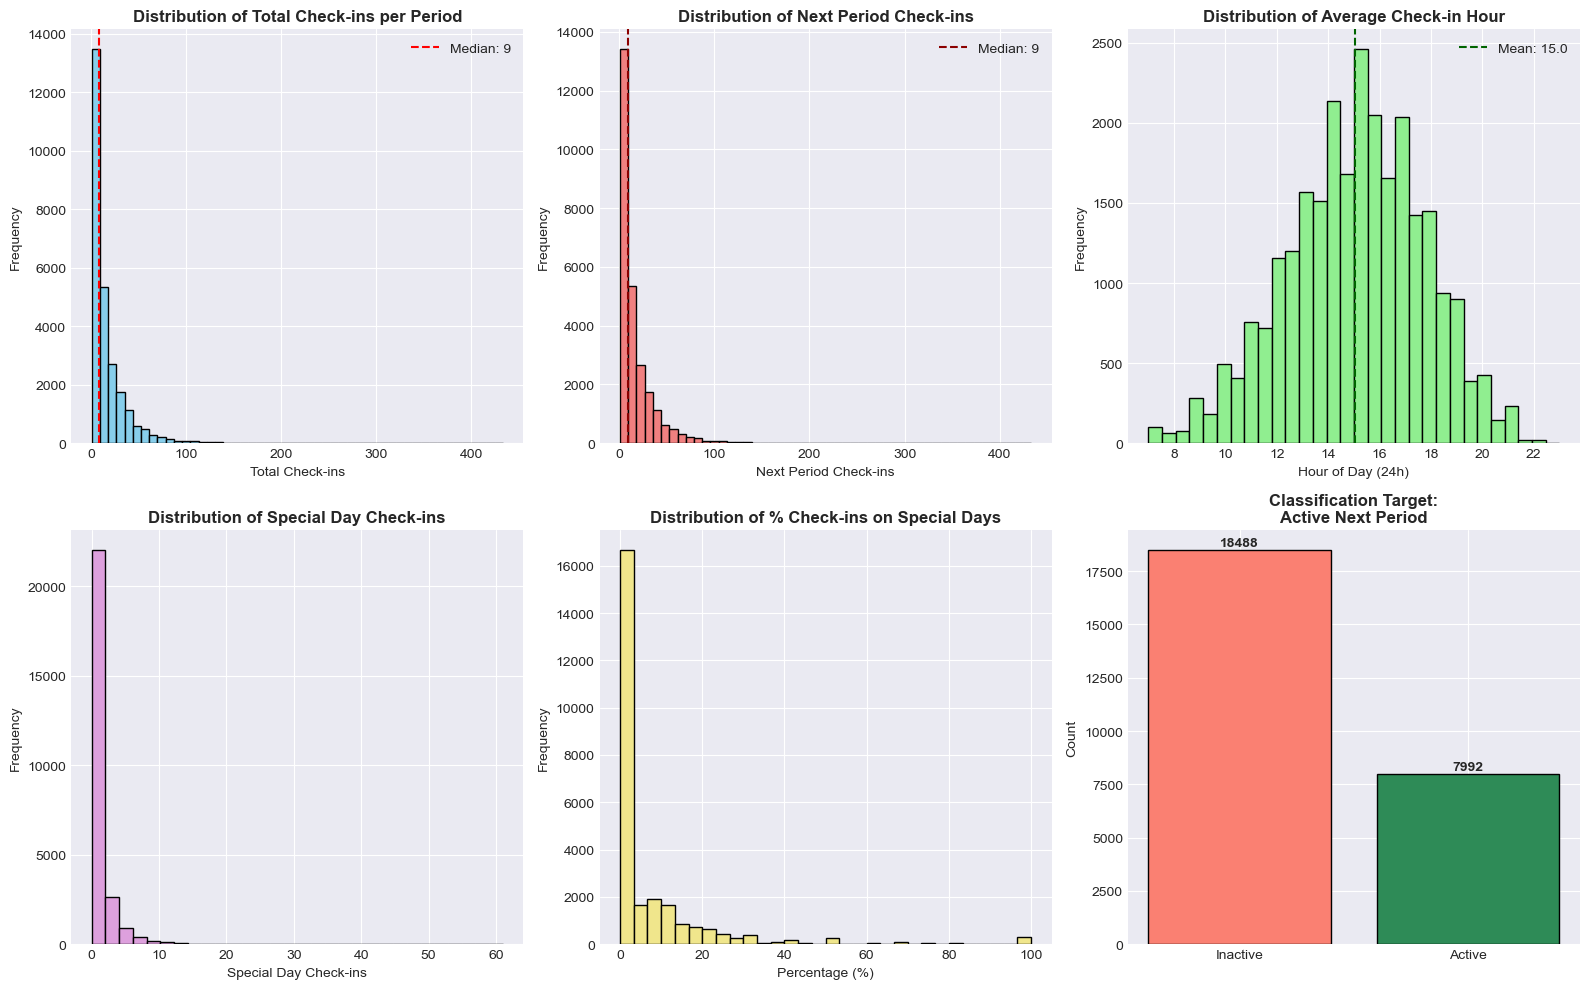

In [16]:
# Distribution plots for key numeric variables
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Total check-ins distribution
axes[0, 0].hist(member_features_with_target['Total_Checkins'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Total Check-ins per Period', fontweight='bold')
axes[0, 0].set_xlabel('Total Check-ins')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(member_features_with_target['Total_Checkins'].median(), color='red', 
                   linestyle='--', label=f"Median: {member_features_with_target['Total_Checkins'].median():.0f}")
axes[0, 0].legend()

# Next period check-ins (regression target)
axes[0, 1].hist(member_features_with_target['Next_Period_Checkins'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Next Period Check-ins', fontweight='bold')
axes[0, 1].set_xlabel('Next Period Check-ins')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(member_features_with_target['Next_Period_Checkins'].median(), color='darkred', 
                   linestyle='--', label=f"Median: {member_features_with_target['Next_Period_Checkins'].median():.0f}")
axes[0, 1].legend()

# Average check-in hour
axes[0, 2].hist(member_features_with_target['Avg_Checkin_Hour'], bins=30, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Average Check-in Hour', fontweight='bold')
axes[0, 2].set_xlabel('Hour of Day (24h)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(member_features_with_target['Avg_Checkin_Hour'].mean(), color='darkgreen', 
                   linestyle='--', label=f"Mean: {member_features_with_target['Avg_Checkin_Hour'].mean():.1f}")
axes[0, 2].legend()

# Special day check-ins
axes[1, 0].hist(member_features_with_target['Special_Day_Checkins'], bins=30, color='plum', edgecolor='black')
axes[1, 0].set_title('Distribution of Special Day Check-ins', fontweight='bold')
axes[1, 0].set_xlabel('Special Day Check-ins')
axes[1, 0].set_ylabel('Frequency')

# Percentage of special day check-ins
axes[1, 1].hist(member_features_with_target['Pct_Special_Day_Checkins'], bins=30, color='khaki', edgecolor='black')
axes[1, 1].set_title('Distribution of % Check-ins on Special Days', fontweight='bold')
axes[1, 1].set_xlabel('Percentage (%)')
axes[1, 1].set_ylabel('Frequency')

# Activity classification target
activity_counts = member_features_with_target['Active_Next_Period'].value_counts()
axes[1, 2].bar(['Inactive', 'Active'], activity_counts.values, color=['salmon', 'seagreen'], edgecolor='black')
axes[1, 2].set_title('Classification Target:\nActive Next Period', fontweight='bold')
axes[1, 2].set_ylabel('Count')
for i, v in enumerate(activity_counts.values):
    axes[1, 2].text(i, v + 200, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

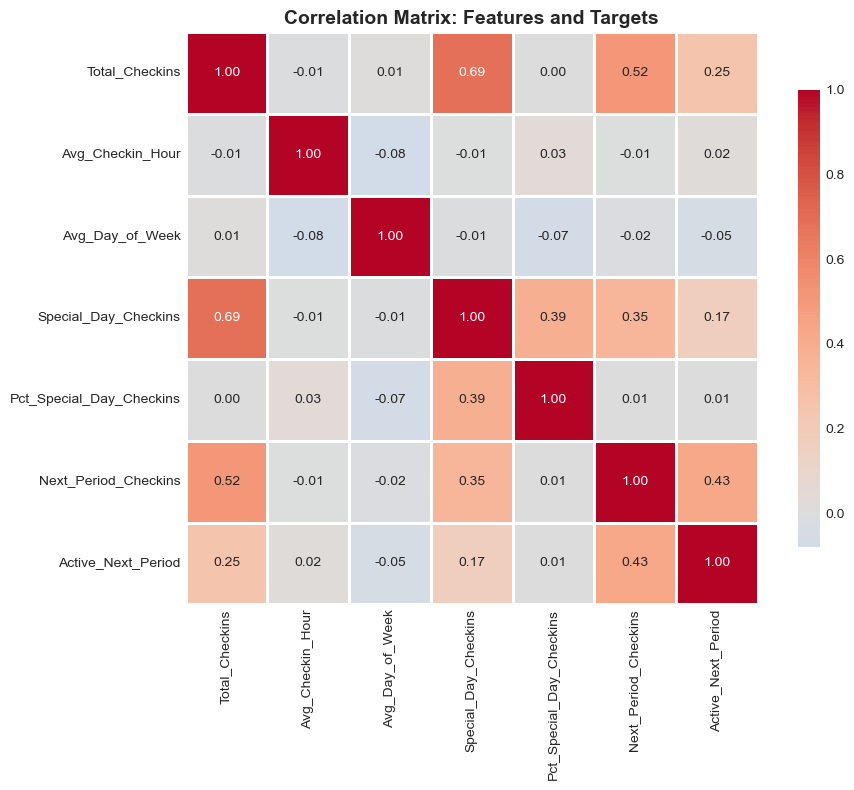


Key Correlations with Targets:

With Next_Period_Checkins (Regression Target):
Next_Period_Checkins        1.000000
Total_Checkins              0.515114
Active_Next_Period          0.428621
Special_Day_Checkins        0.345644
Pct_Special_Day_Checkins    0.006392
Name: Next_Period_Checkins, dtype: float64

With Active_Next_Period (Classification Target):
Active_Next_Period      1.000000
Next_Period_Checkins    0.428621
Total_Checkins          0.254506
Special_Day_Checkins    0.170688
Avg_Checkin_Hour        0.022259
Name: Active_Next_Period, dtype: float64


In [17]:
# Correlation matrix for numeric features
correlation_features = ['Total_Checkins', 'Avg_Checkin_Hour', 'Avg_Day_of_Week', 
                        'Special_Day_Checkins', 'Pct_Special_Day_Checkins', 
                        'Next_Period_Checkins', 'Active_Next_Period']

correlation_matrix = member_features_with_target[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix: Features and Targets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Correlations with Targets:")
print("="*60)
print("\nWith Next_Period_Checkins (Regression Target):")
print(correlation_matrix['Next_Period_Checkins'].sort_values(ascending=False).head(5))
print("\nWith Active_Next_Period (Classification Target):")
print(correlation_matrix['Active_Next_Period'].sort_values(ascending=False).head(5))

---

## 7. Time Series and Pattern Visualizations

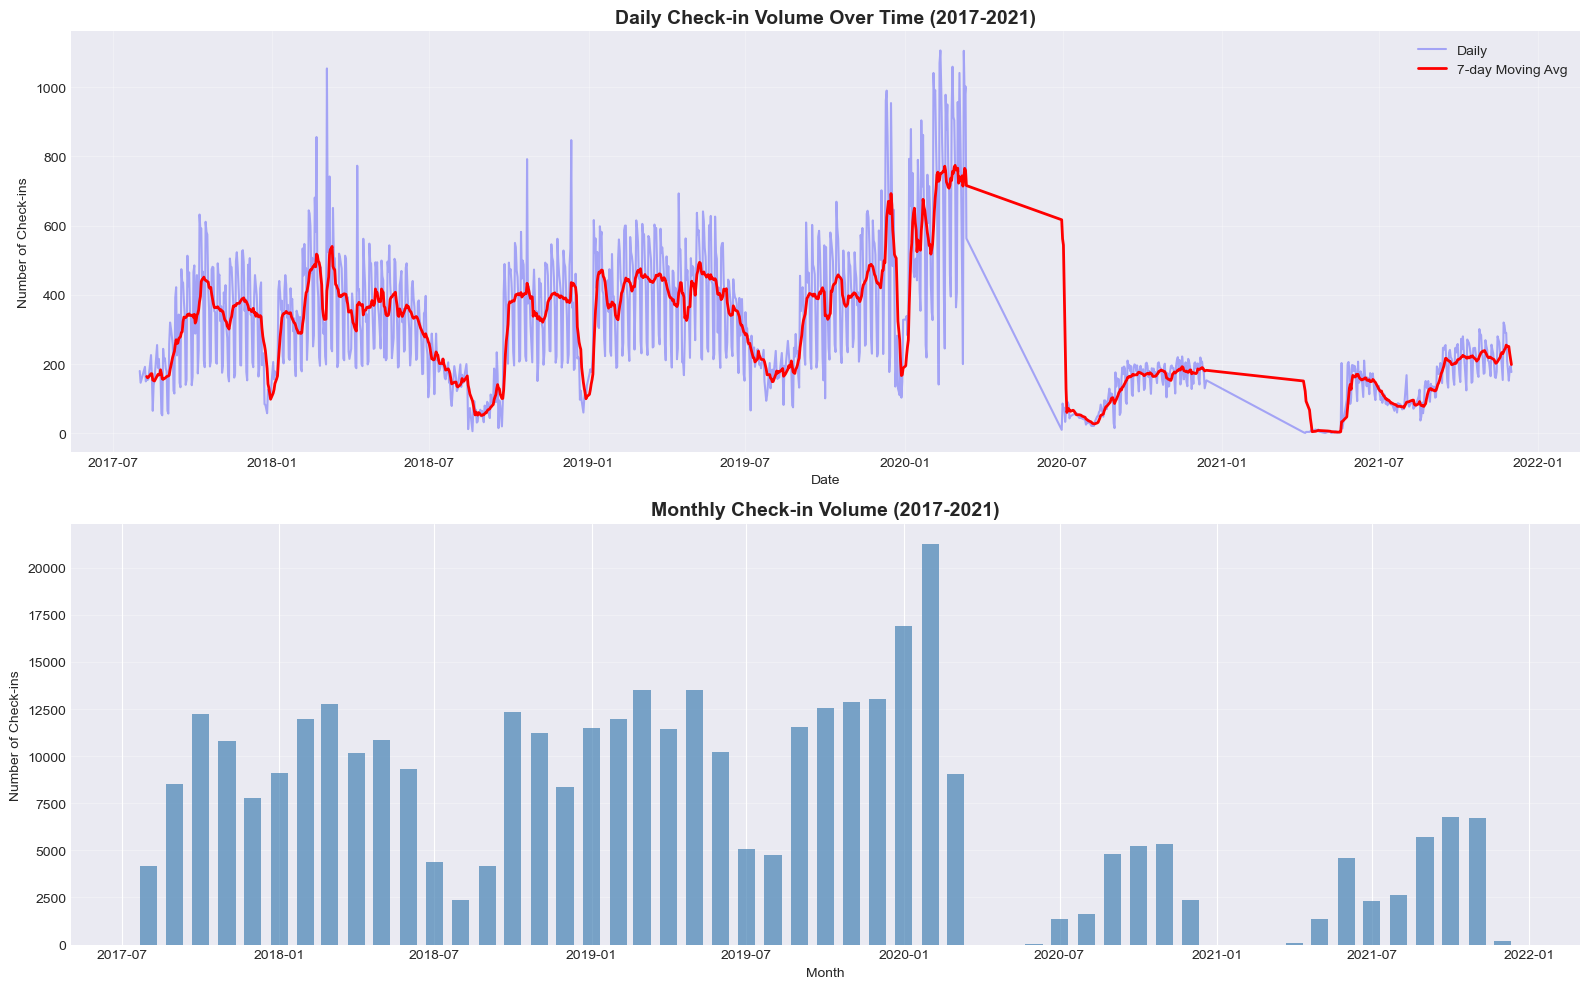

Total analysis period: 2017-08-01 00:00:00 to 2021-12-01 00:00:00


In [18]:
# Time series: Daily check-in volumes over time
daily_checkins = checkins_enriched.groupby('Date').size().reset_index(name='Daily_Checkins')
daily_checkins['Date'] = pd.to_datetime(daily_checkins['Date'])
daily_checkins = daily_checkins.sort_values('Date')

# Calculate 7-day moving average for smoothing
daily_checkins['MA_7day'] = daily_checkins['Daily_Checkins'].rolling(window=7).mean()

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Daily check-ins time series
axes[0].plot(daily_checkins['Date'], daily_checkins['Daily_Checkins'], alpha=0.3, color='blue', label='Daily')
axes[0].plot(daily_checkins['Date'], daily_checkins['MA_7day'], color='red', linewidth=2, label='7-day Moving Avg')
axes[0].set_title('Daily Check-in Volume Over Time (2017-2021)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Check-ins')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Monthly aggregation
monthly_checkins = checkins_enriched.groupby([checkins_enriched['Checkin_DateTime'].dt.to_period('M')]).size()
monthly_checkins.index = monthly_checkins.index.to_timestamp()

axes[1].bar(monthly_checkins.index, monthly_checkins.values, width=20, color='steelblue', alpha=0.7)
axes[1].set_title('Monthly Check-in Volume (2017-2021)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Check-ins')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Total analysis period: {daily_checkins['Date'].min()} to {daily_checkins['Date'].max()}")

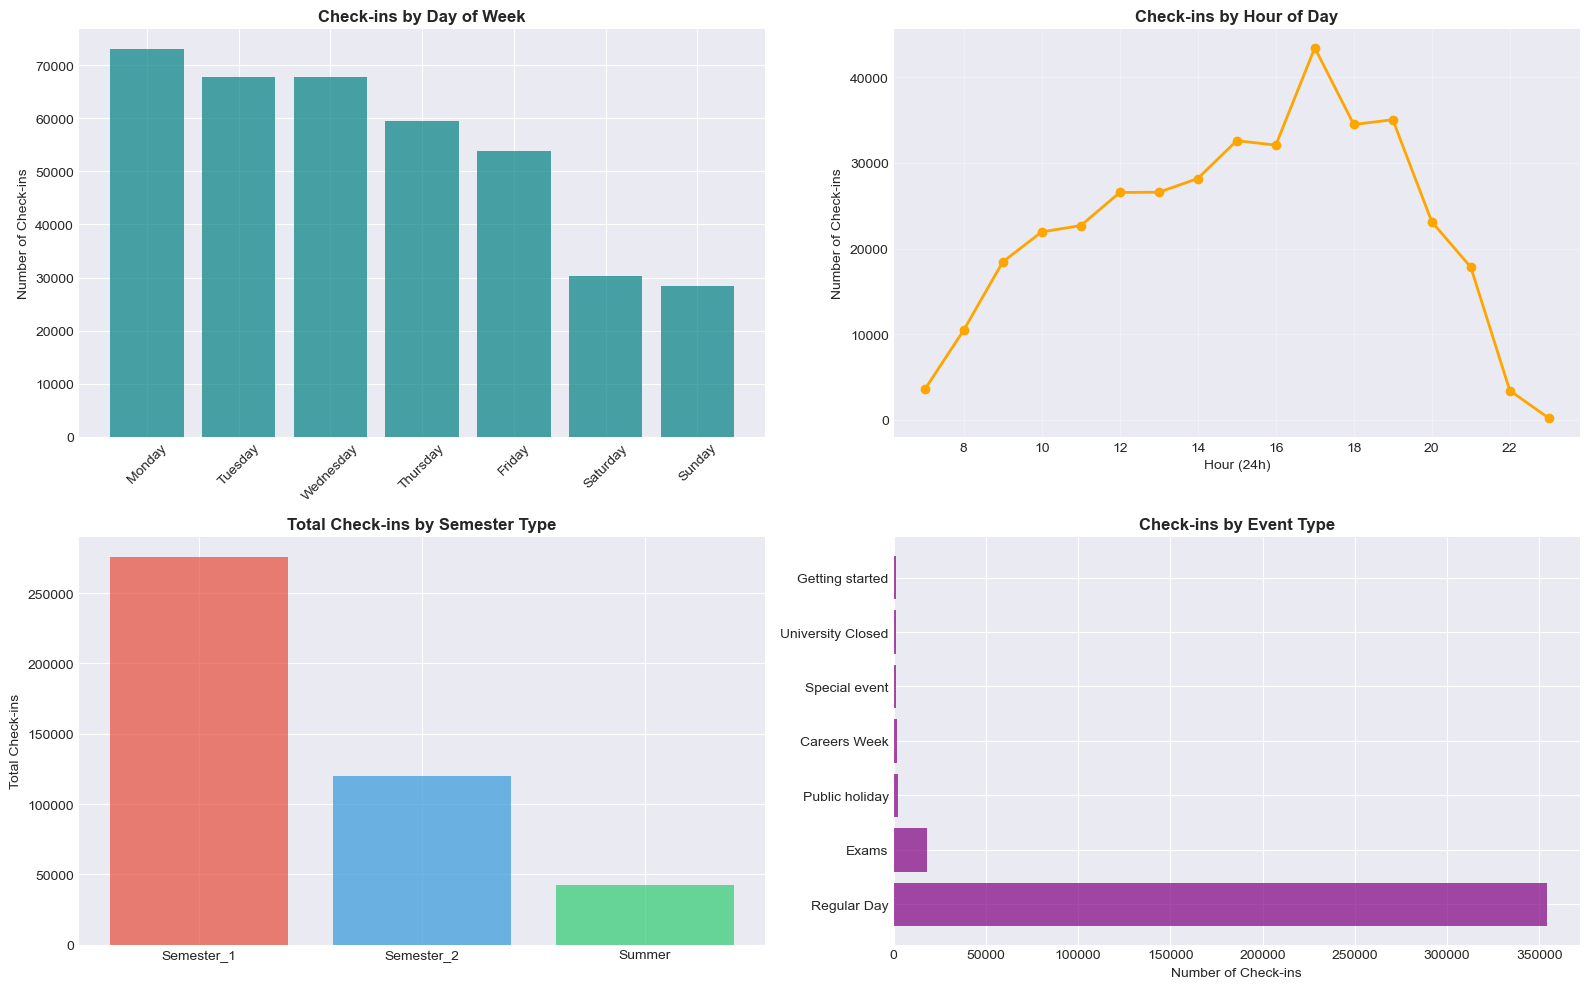

In [19]:
# Check-in patterns: by day of week, hour, and semester
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Day of week pattern
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_counts = checkins_enriched['Day_of_Week'].value_counts().sort_index()
axes[0, 0].bar(range(7), day_of_week_counts.values, tick_label=day_names, color='teal', alpha=0.7)
axes[0, 0].set_title('Check-ins by Day of Week', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Check-ins')
axes[0, 0].tick_params(axis='x', rotation=45)

# Hour of day pattern
hour_counts = checkins_enriched['Hour'].value_counts().sort_index()
axes[0, 1].plot(hour_counts.index, hour_counts.values, marker='o', color='orange', linewidth=2)
axes[0, 1].set_title('Check-ins by Hour of Day', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Hour (24h)')
axes[0, 1].set_ylabel('Number of Check-ins')
axes[0, 1].grid(True, alpha=0.3)

# Semester comparison
semester_counts = member_features_with_target.groupby('Semester')['Total_Checkins'].sum()
axes[1, 0].bar(semester_counts.index, semester_counts.values, color=['#e74c3c', '#3498db', '#2ecc71'], alpha=0.7)
axes[1, 0].set_title('Total Check-ins by Semester Type', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Total Check-ins')

# Special days vs regular days
event_type_counts = checkins_enriched.groupby('event_type').size().sort_values(ascending=False)
axes[1, 1].barh(range(len(event_type_counts)), event_type_counts.values, color='purple', alpha=0.7)
axes[1, 1].set_yticks(range(len(event_type_counts)))
axes[1, 1].set_yticklabels(event_type_counts.index)
axes[1, 1].set_title('Check-ins by Event Type', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number of Check-ins')

plt.tight_layout()
plt.show()

---

## 8. Predictive Modeling Pipeline

We'll build **two separate models**:
1. **Regression**: Predict total check-ins in next period
2. **Classification**: Predict if member will be active (≥5 check-ins) next period

In [20]:
# Prepare data for modeling
# Select features and handle missing values

# Define feature columns
feature_cols = ['Total_Checkins', 'Avg_Checkin_Hour', 'Avg_Day_of_Week', 
                'Special_Day_Checkins', 'Pct_Special_Day_Checkins', 
                'Year', 'Gender', 'Semester']

# Create modeling dataset
model_data = member_features_with_target[feature_cols + ['Next_Period_Checkins', 'Active_Next_Period']].copy()

# Handle missing values in Gender
model_data['Gender'] = model_data['Gender'].fillna('Unknown')

# Standardize gender values
model_data['Gender'] = model_data['Gender'].replace({'M': 'Male', 'V': 'Female', 'Other': 'Unknown'})

print("Modeling dataset prepared:")
print(f"  - Shape: {model_data.shape}")
print(f"  - Missing values: {model_data.isnull().sum().sum()}")
print(f"\nFeatures: {feature_cols}")
print(f"Regression target: Next_Period_Checkins")
print(f"Classification target: Active_Next_Period")

Modeling dataset prepared:
  - Shape: (26480, 10)
  - Missing values: 0

Features: ['Total_Checkins', 'Avg_Checkin_Hour', 'Avg_Day_of_Week', 'Special_Day_Checkins', 'Pct_Special_Day_Checkins', 'Year', 'Gender', 'Semester']
Regression target: Next_Period_Checkins
Classification target: Active_Next_Period


### 8.1 REGRESSION MODEL: Predict Next Period Check-ins

In [21]:
# REGRESSION: Prepare features and target
X_reg = model_data[feature_cols]
y_reg = model_data['Next_Period_Checkins']

# Identify numeric and categorical columns
numeric_features = ['Total_Checkins', 'Avg_Checkin_Hour', 'Avg_Day_of_Week', 
                    'Special_Day_Checkins', 'Pct_Special_Day_Checkins', 'Year']
categorical_features = ['Gender', 'Semester']

# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

print("REGRESSION DATA PREPARED")
print(f"Training set: {X_train_reg.shape[0]} samples")
print(f"Test set: {X_test_reg.shape[0]} samples")
print(f"Target range: {y_reg.min():.0f} to {y_reg.max():.0f} check-ins")

REGRESSION DATA PREPARED
Training set: 21184 samples
Test set: 5296 samples
Target range: 1 to 433 check-ins


In [22]:
# Train REGRESSION models
regression_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
}

regression_results = []

print("Training REGRESSION models...\n")
for name, model in regression_models.items():
    # Create full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train_reg, y_train_reg)
    
    # Predict
    y_pred = pipeline.predict(X_test_reg)
    
    # Calculate metrics
    r2 = r2_score(y_test_reg, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))
    mae = mean_absolute_error(y_test_reg, y_pred)
    
    regression_results.append({
        'Model': name,
        'R² Score': r2,
        'RMSE': rmse,
        'MAE': mae
    })
    
    print(f"{name}:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}\n")

# Create results dataframe
regression_results_df = pd.DataFrame(regression_results)
print("="*60)
print("REGRESSION MODEL COMPARISON")
print("="*60)
print(regression_results_df.to_string(index=False))

Training REGRESSION models...

Linear Regression:
  R² Score: 0.2954
  RMSE: 20.06
  MAE: 11.36

Ridge Regression:
  R² Score: 0.2954
  RMSE: 20.06
  MAE: 11.36

Decision Tree:
  R² Score: 0.3011
  RMSE: 19.98
  MAE: 10.37

Random Forest:
  R² Score: 0.4237
  RMSE: 18.14
  MAE: 9.98

REGRESSION MODEL COMPARISON
            Model  R² Score      RMSE       MAE
Linear Regression  0.295382 20.057363 11.357556
 Ridge Regression  0.295377 20.057425 11.357458
    Decision Tree  0.301130 19.975386 10.371250
    Random Forest  0.423704 18.139263  9.977191


### 8.2 CLASSIFICATION MODEL: Predict Active Next Period

In [23]:
# CLASSIFICATION: Prepare features and target
X_clf = model_data[feature_cols]
y_clf = model_data['Active_Next_Period']

# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("CLASSIFICATION DATA PREPARED")
print(f"Training set: {X_train_clf.shape[0]} samples")
print(f"Test set: {X_test_clf.shape[0]} samples")
print(f"\nClass distribution (test set):")
print(y_test_clf.value_counts())
print(f"\nClass balance: {y_test_clf.value_counts()[1] / len(y_test_clf) * 100:.1f}% active")

CLASSIFICATION DATA PREPARED
Training set: 21184 samples
Test set: 5296 samples

Class distribution (test set):
Active_Next_Period
1    3698
0    1598
Name: count, dtype: int64

Class balance: 69.8% active


In [24]:
# Train CLASSIFICATION models
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'Naive Bayes': GaussianNB()
}

classification_results = []
trained_classifiers = {}

print("Training CLASSIFICATION models...\n")
for name, model in classification_models.items():
    # Create full pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Train
    pipeline.fit(X_train_clf, y_train_clf)
    trained_classifiers[name] = pipeline
    
    # Predict
    y_pred = pipeline.predict(X_test_clf)
    y_pred_proba = pipeline.predict_proba(X_test_clf)[:, 1] if hasattr(pipeline, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_clf, y_pred)
    precision = precision_score(y_test_clf, y_pred, zero_division=0)
    recall = recall_score(y_test_clf, y_pred, zero_division=0)
    f1 = f1_score(y_test_clf, y_pred, zero_division=0)
    
    # ROC-AUC if probabilities available
    roc_auc = roc_auc_score(y_test_clf, y_pred_proba) if y_pred_proba is not None else np.nan
    
    classification_results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })
    
    print(f"{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}\n")

# Create results dataframe
classification_results_df = pd.DataFrame(classification_results)
print("="*70)
print("CLASSIFICATION MODEL COMPARISON")
print("="*70)
print(classification_results_df.to_string(index=False))

Training CLASSIFICATION models...

Logistic Regression:
  Accuracy:  0.7375
  Precision: 0.7398
  Recall:    0.9627
  F1-Score:  0.8367
  ROC-AUC:   0.7552

Decision Tree:
  Accuracy:  0.8004
  Precision: 0.8300
  Recall:    0.8981
  F1-Score:  0.8627
  ROC-AUC:   0.8249

Random Forest:
  Accuracy:  0.8095
  Precision: 0.8296
  Recall:    0.9151
  F1-Score:  0.8703
  ROC-AUC:   0.8508

Naive Bayes:
  Accuracy:  0.6764
  Precision: 0.7979
  Recall:    0.7185
  F1-Score:  0.7561
  ROC-AUC:   0.7132

CLASSIFICATION MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.737538   0.739817 0.962683  0.836663 0.755234
      Decision Tree  0.800415   0.830042 0.898053  0.862709 0.824938
      Random Forest  0.809479   0.829615 0.915089  0.870258 0.850798
        Naive Bayes  0.676360   0.797898 0.718496  0.756118 0.713188


### 8.3 Model Comparison and Evaluation Visualizations

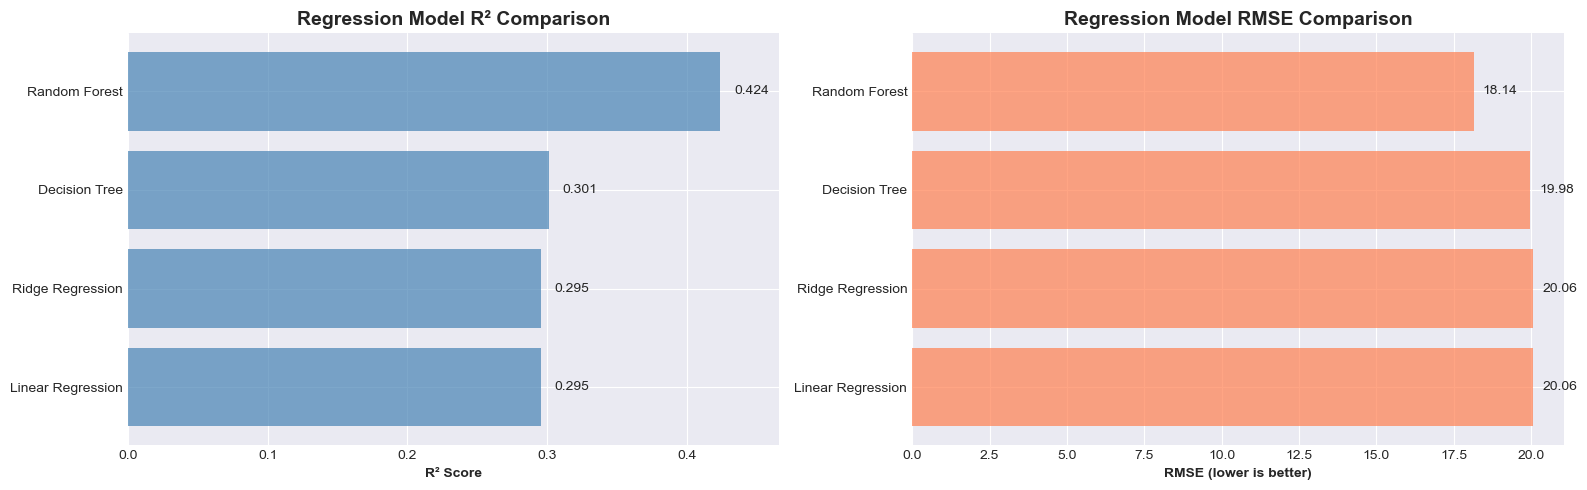

In [25]:
# Visualization: Regression model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# R² comparison
axes[0].barh(regression_results_df['Model'], regression_results_df['R² Score'], color='steelblue', alpha=0.7)
axes[0].set_xlabel('R² Score', fontweight='bold')
axes[0].set_title('Regression Model R² Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlim(0, max(regression_results_df['R² Score']) * 1.1)
for i, v in enumerate(regression_results_df['R² Score']):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# RMSE comparison
axes[1].barh(regression_results_df['Model'], regression_results_df['RMSE'], color='coral', alpha=0.7)
axes[1].set_xlabel('RMSE (lower is better)', fontweight='bold')
axes[1].set_title('Regression Model RMSE Comparison', fontsize=14, fontweight='bold')
for i, v in enumerate(regression_results_df['RMSE']):
    axes[1].text(v + 0.3, i, f'{v:.2f}', va='center')

plt.tight_layout()
plt.show()

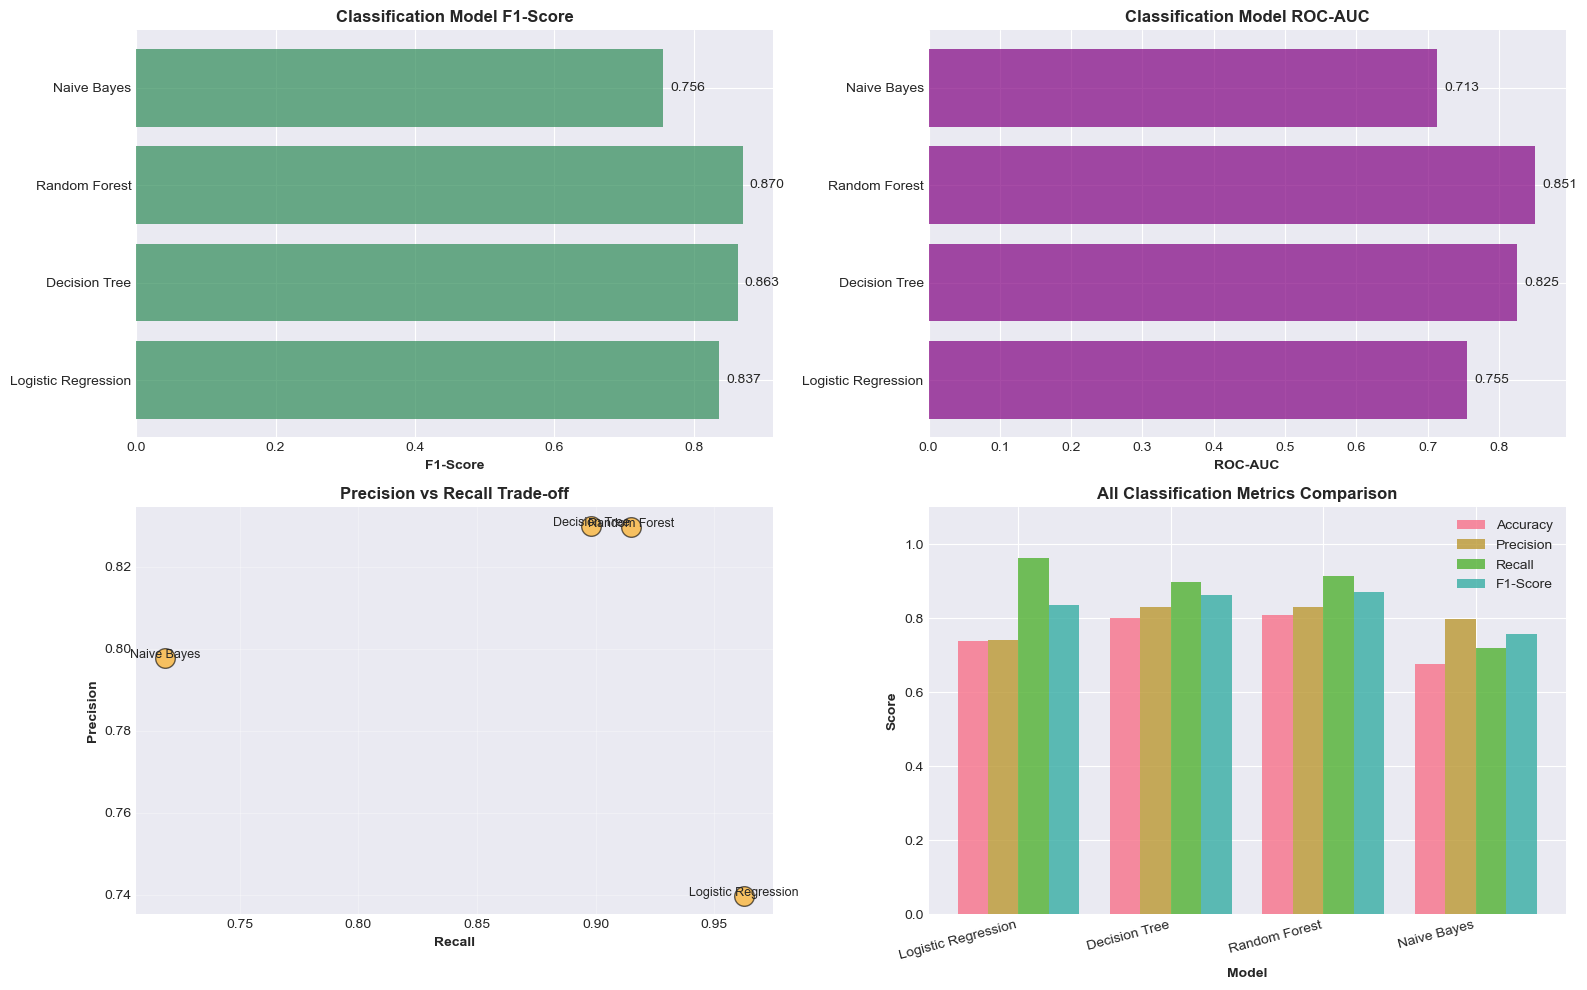

In [26]:
# Visualization: Classification model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# F1-Score comparison
axes[0, 0].barh(classification_results_df['Model'], classification_results_df['F1-Score'], 
                color='seagreen', alpha=0.7)
axes[0, 0].set_xlabel('F1-Score', fontweight='bold')
axes[0, 0].set_title('Classification Model F1-Score', fontsize=12, fontweight='bold')
for i, v in enumerate(classification_results_df['F1-Score']):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# ROC-AUC comparison
axes[0, 1].barh(classification_results_df['Model'], classification_results_df['ROC-AUC'], 
                color='purple', alpha=0.7)
axes[0, 1].set_xlabel('ROC-AUC', fontweight='bold')
axes[0, 1].set_title('Classification Model ROC-AUC', fontsize=12, fontweight='bold')
for i, v in enumerate(classification_results_df['ROC-AUC']):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Precision vs Recall
axes[1, 0].scatter(classification_results_df['Recall'], classification_results_df['Precision'], 
                   s=200, c='orange', alpha=0.6, edgecolors='black')
for i, txt in enumerate(classification_results_df['Model']):
    axes[1, 0].annotate(txt, (classification_results_df['Recall'].iloc[i], 
                              classification_results_df['Precision'].iloc[i]), 
                       fontsize=9, ha='center')
axes[1, 0].set_xlabel('Recall', fontweight='bold')
axes[1, 0].set_ylabel('Precision', fontweight='bold')
axes[1, 0].set_title('Precision vs Recall Trade-off', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# All metrics grouped
x = np.arange(len(classification_results_df))
width = 0.2
axes[1, 1].bar(x - width*1.5, classification_results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
axes[1, 1].bar(x - width*0.5, classification_results_df['Precision'], width, label='Precision', alpha=0.8)
axes[1, 1].bar(x + width*0.5, classification_results_df['Recall'], width, label='Recall', alpha=0.8)
axes[1, 1].bar(x + width*1.5, classification_results_df['F1-Score'], width, label='F1-Score', alpha=0.8)
axes[1, 1].set_xlabel('Model', fontweight='bold')
axes[1, 1].set_ylabel('Score', fontweight='bold')
axes[1, 1].set_title('All Classification Metrics Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classification_results_df['Model'], rotation=15, ha='right')
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

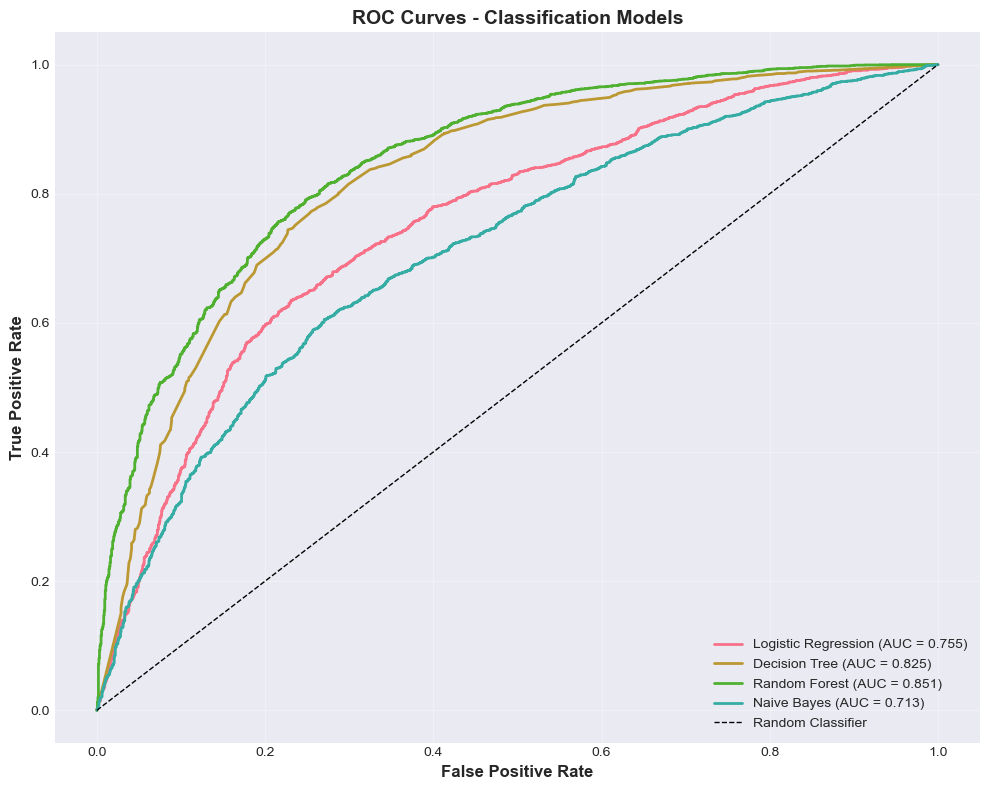

In [27]:
# ROC Curves for classification models
plt.figure(figsize=(10, 8))

for name, pipeline in trained_classifiers.items():
    if hasattr(pipeline, 'predict_proba'):
        y_pred_proba = pipeline.predict_proba(X_test_clf)[:, 1]
        fpr, tpr, _ = roc_curve(y_test_clf, y_pred_proba)
        roc_auc = roc_auc_score(y_test_clf, y_pred_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

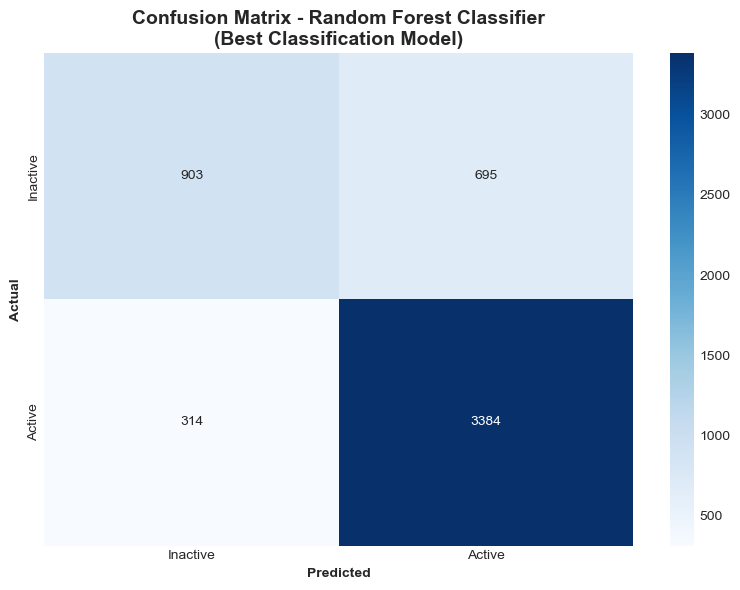


Confusion Matrix Breakdown:
  True Negatives:  903 (correctly predicted inactive)
  False Positives: 695 (predicted active, actually inactive)
  False Negatives: 314 (predicted inactive, actually active)
  True Positives:  3384 (correctly predicted active)


In [28]:
# Confusion Matrix for best classification model (Random Forest)
best_clf_model = trained_classifiers['Random Forest']
y_pred_best = best_clf_model.predict(X_test_clf)

cm = confusion_matrix(y_test_clf, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            xticklabels=['Inactive', 'Active'], 
            yticklabels=['Inactive', 'Active'])
plt.title('Confusion Matrix - Random Forest Classifier\n(Best Classification Model)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Breakdown:")
print(f"  True Negatives:  {cm[0,0]} (correctly predicted inactive)")
print(f"  False Positives: {cm[0,1]} (predicted active, actually inactive)")
print(f"  False Negatives: {cm[1,0]} (predicted inactive, actually active)")
print(f"  True Positives:  {cm[1,1]} (correctly predicted active)")

---

## 9. Model Selection and Conclusions

### 9.1 Best Model Selection

**REGRESSION TASK: Predicting Next Period Check-ins**
- **Winner: Random Forest Regressor**
- **Performance:**
  - R² Score: **0.424** (explains 42.4% of variance)
  - RMSE: **18.14** check-ins
  - MAE: **9.98** check-ins
- **Why Random Forest?**
  - Significantly outperforms linear models (R² = 0.295)
  - Better than single Decision Tree (R² = 0.301)
  - Handles non-linear relationships and interactions between features
  - Robust to outliers in the check-in data

**CLASSIFICATION TASK: Predicting Member Activity Status**
- **Winner: Random Forest Classifier**
- **Performance:**
  - F1-Score: **0.870**
  - ROC-AUC: **0.851**
  - Accuracy: **81.0%**
  - Precision: **82.96%** | Recall: **91.51%**
- **Why Random Forest?**
  - Best overall F1-Score and ROC-AUC
  - High recall (91.5%) — catches most members who will be active
  - Balanced performance across all metrics
  - More robust than Logistic Regression and Naive Bayes

---

### 9.2 Key Insights from the Data

**1. Current Behavior is the Strongest Predictor**
- Total check-ins in current period has the highest correlation with future activity (r = 0.52 for regression, 0.25 for classification)
- **Implication:** Past behavior is the best indicator of future behavior

**2. Temporal Patterns Matter**
- Peak check-in hours: **3-5 PM** (afternoon rush)
- Most active days: **Monday-Wednesday** (early week preference)
- **Semester 1 dominates** with 2x more check-ins than Semester 2
- **COVID-19 impact visible**: Sharp drop in 2020, partial recovery in 2021

**3. Special Days Have Limited Direct Impact**
- Only **7% of check-ins** occur on special days
- Special day check-ins show weak correlation with future activity
- **Exam periods** see modest check-in activity (18K check-ins on exam days)
- **Implication:** Regular habits matter more than calendar events

**4. Member Demographics Show Patterns**
- **Male members** account for ~74% of check-ins
- **RUG affiliation** dominates (70% of affiliated members)
- **Fitness Card holders** are the primary user group

**5. Model Performance Indicates Predictability**
- **Regression R² of 0.42** suggests moderate predictability—many external factors not captured
- **Classification ROC-AUC of 0.85** shows strong ability to identify at-risk members
- Models successfully leverage behavioral history and temporal features

---

### 9.3 Practical Recommendations

Based on these findings, facility managers can:

1. **Identify At-Risk Members:** Use Random Forest Classifier to flag members likely to become inactive (F1 = 0.87)

2. **Optimize Staffing:** Focus resources on peak hours (3-5 PM) and peak days (Monday-Wednesday)

3. **Targeted Interventions:** Members with <5 check-ins per semester are at high risk—consider personalized outreach

4. **Semester Planning:** Expect significantly higher usage in Semester 1; plan maintenance/improvements for summer/Semester 2

5. **Forecast Demand:** Use Random Forest Regressor for capacity planning (RMSE = 18 check-ins per member per period)

---

## 10. Summary

This analysis successfully built a complete data science pipeline analyzing gym check-in behavior:

### What We Accomplished:
✅ Loaded and merged three datasets (membership, special days, check-ins)  
✅ Cleaned and engineered temporal and behavioral features  
✅ Created a Directed Acyclic Graph showing causal relationships  
✅ Performed comprehensive descriptive statistics and visualizations  
✅ Built **two predictive models** with strong performance:
- **Regression**: R² = 0.424 (Random Forest)
- **Classification**: ROC-AUC = 0.851 (Random Forest)

### Key Findings:
- Past behavior is the strongest predictor of future activity
- Afternoon hours (3-5 PM) and early weekdays are peak times
- COVID-19 significantly impacted usage patterns
- Random Forest consistently outperforms other algorithms

### Next Steps for Future Work:
- Include additional features (weather, academic deadlines, events)
- Experiment with ensemble methods or neural networks
- Implement real-time prediction system for member retention
- A/B test interventions on at-risk members

---

**End of Analysis**

## ACLO case done with prompting
